In [4]:
import config

In [6]:
pip install alpaca-py

  Using cached alpaca_py-0.42.0-py3-none-any.whl.metadata (13 kB)
  Using cached sseclient_py-1.8.0-py2.py3-none-any.whl.metadata (2.0 kB)
Using cached alpaca_py-0.42.0-py3-none-any.whl (121 kB)
Using cached sseclient_py-1.8.0-py2.py3-none-any.whl (8.8 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
import config
from alpaca.trading.client import TradingClient
trading_client = TradingClient(config.ALPACA_API_KEY, config.ALPACA_SECRET_KEY, paper=True)

In [11]:
trading_client

In [35]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import config
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


data_client = StockHistoricalDataClient(config.ALPACA_API_KEY, config.ALPACA_SECRET_KEY)

def get_candles(timeframe):
    request_params = StockBarsRequest(
        symbol_or_symbols=["AAPL"],  
        timeframe=timeframe,      
        start=datetime(2024, 8, 1),   
        end=datetime(2024, 8, 10)     
    )

    bars = data_client.get_stock_bars(request_params)

    df = bars.df.reset_index()  

    candle = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    return candle

In [22]:
import matplotlib.pyplot as plt

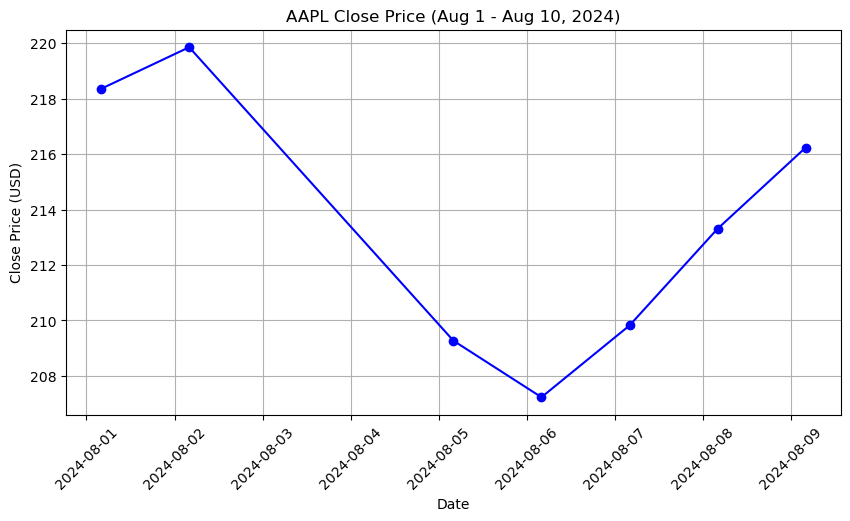

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(candle['timestamp'], candle['close'], marker='o', linestyle='-', color='blue')
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.title("AAPL Close Price (Aug 1 - Aug 10, 2024)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [36]:
price = get_candles(TimeFrame.Hour)
price.head()

,timestamp,open,high,low,close,volume
0,2024-08-01 08:00:00+00:00,223.80,223.80,222.70,223.05,44591.0
1,2024-08-01 09:00:00+00:00,223.26,223.65,223.26,223.62,18201.0
2,2024-08-01 10:00:00+00:00,223.60,224.08,223.60,224.00,25534.0
3,2024-08-01 11:00:00+00:00,224.00,224.84,223.97,224.25,136537.0
4,2024-08-01 12:00:00+00:00,223.98,224.88,223.50,224.44,335241.0


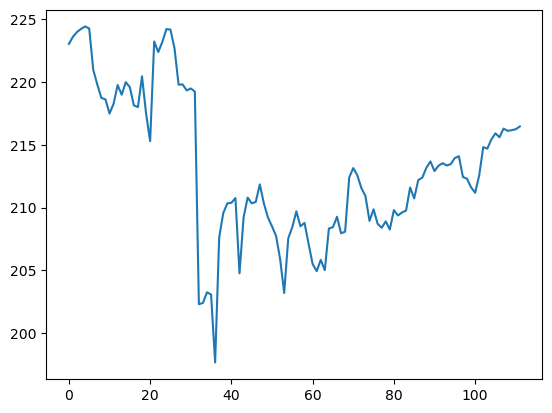

In [37]:
plt.plot(price['close'])